In [4]:
# Import all necessary packages
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from tick.base import TimeFunction
from tick.hawkes import SimuInhomogeneousPoisson

In [5]:
# Parameters for arrival processes
numPatients = 30 # Input roughly the scale of the incident. I.e. how many patients do you expect?
peakR = 2.5 # This parameter controls when the peak of arrivals is for red patients
peakG = 1.5 # This parameter controls when the peak of arrivals is for green patients
ratio = 2/3 # Ratio of red patients to green patients

# Compute parameters for functions
cG = numPatients / (1+ratio)
cR = numPatients - cG

In [6]:
# Define patient arrival rate function
def lam(time, c, a):
    t = time/60
    out = c / 60 * (t)**(a-1)*np.exp(-t)/(gamma(a))
    return out


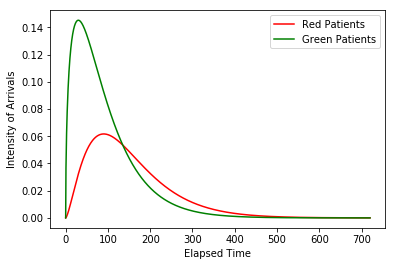

In [7]:
# Lets plot the arrival rate functions for both classes of patients
tp = np.linspace(0, 720, num = 1000)
plt.plot(tp, lam(tp, cR, peakR), label='Red Patients', color='red') # First plot for red patients
plt.plot(tp, lam(tp, cG, peakG), label='Green Patients', color='green') # First plot for green patients
plt.xlabel('Elapsed Time')
plt.ylabel('Intensity of Arrivals')
plt.legend()
plt.show() 

In [8]:
# Parameters of survival probabilities
initR = .5 # Initial survival probability for red
initG = .8 # Initial survival probability for green
platR = 2 # Legnth of plateau for red
platG = 3 # Legnth of plateau for green
decR = 1.5 # Rate of decay for red
decG = 2 # Rate of decay for green

In [9]:
# Parameters of survival probabilities
def survival(time, b0, b1, b2):
    t = time/60
    out = b0 / ((t/b1)**b2 + 1)
    return out

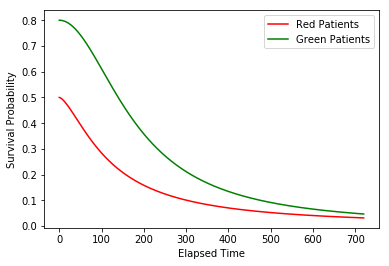

In [10]:
tp = np.linspace(0, 720, num = 1000)
plt.plot(tp, survival(tp, initR, platR, decR), label='Red Patients', color='red') # First plot for red patients
plt.plot(tp, survival(tp, initG, platG, decG), label='Green Patients', color='green') # First plot for red patients
plt.xlabel('Elapsed Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show() 

In [13]:
# Simulation Parameters
reps = 1000
numBeds = 50
divTime = 50
policy = 'Red Only'

In [14]:
# Run simulation
tp = np.linspace(0, 720, num = 1000)
yr = lam(tp, cR, peakR)
yg = lam(tp, cG, peakG)
tf = TimeFunction((tp, yr+yg))
died = np.zeros(reps)
survived = np.zeros(reps)
for i in range(reps): 
    pp = SimuInhomogeneousPoisson([tf], end_time=720, verbose=False)
    pp.simulate()
    times = pp.timestamps
    bedsRemaining = numBeds
    for t in times[0]:
        is_red = np.random.binomial(1, lam(t, cR, peakR)/(lam(t, cR, peakR)+lam(t, cG, peakG)))
        if policy == 'FCFS':
            if bedsRemaining > 0:
                admit = 1
            else:
                admit = 0
        elif policy == 'Red Only':
            if bedsRemaining > 0 and is_red == 1:
                admit = 1
            else:
                admit = 0
        elif policy == 'Green Only':
            if bedsRemaining > 0 and is_red == 0:
                admit = 1
            else:
                admit = 0
        
        if admit == 1:
            bedsRemaining += -1
            if is_red == 1:
                survived[i] += np.random.binomial(1, survival(t, initR, platR, decR))
            else:
                survived[i] += np.random.binomial(1, survival(t, initG, platG, decG))
        else:
            if is_red == 1:
                survived[i] += np.random.binomial(1, survival(t+divTime, initR, platR, decR))
            else:
                survived[i] += np.random.binomial(1, survival(t+divTime, initG, platG, decG))
        
    died[i] = len(times[0]) - survived[i]
print(np.mean(died))
print(np.mean(survived))
        

17.794
12.267
